In [128]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [129]:
import MaxQuant_Postprocessing_Functions as mq
import re
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [130]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# Classify mouse tissue using protein and peptide abundance data
* Use proteinGroups.txt or peptides.txt outputted from MaxQuant
* SVC variations
* K neighbors
* Decision tree

** With train-test split, test_size = 0.4:**

Algorithm | Accuracy Score
:-----:|:-----:
SVC kernel = linear | 1.0
LinearSVC | 0.75 \*
SVC kernel = rbf | 0.167
SVC kernel = poly | 1.0
KNN | 1.0
Decision Tree | 0.67 \*

\* varies

## Load and clean mouse data

In [131]:
file = "D:\proteinGroups.txt"

df = mq.load_df(file)
df = mq.clean_weakly_identified(df)
df = mq.remove_dup_proteinIDs(df)

iBAQ_df = mq.slice_by_column(df, 'protein', 'iBAQ ')

# Rename columns so that all instances "before" string are replaced with "after" string
def rename_columns(df, before, after):
    columns = df.columns.values.tolist()
    new_columns = []
    for column in columns:
        new_column = re.sub(before, after, column)
        new_columns.append(new_column)
        
    return new_columns

iBAQ_df.columns = rename_columns(iBAQ_df, 'Adult', 'Mouse')

groups = ['Brain', 'Heart', 'Kidney', 'Liver', 'Lung']
organ_columns = {} # 'Liver': ['iBAQ 04_Liver', 'iBAQ 05_Liver', ...]
organ_counts = {} # 'Liver': 
    
iBAQ_df = mq.filter_low_observed(iBAQ_df, groups, organ_columns, organ_counts)

### Arbitrarily threshold data

In [132]:
### Replace low abundance values with 0
def replace_with_zero(x):
    min_val = 7
    
    if type(x) is str:
        return x
    
    elif pd.isnull(x) or x < min_val:
        return 0
    
    else:
        return x
    
iBAQ_df.applymap(replace_with_zero)

,Majority protein IDs,iBAQ Mouse_04_Liver,iBAQ Mouse_05_Liver,iBAQ Mouse_06_Liver,iBAQ Mouse_07_Brain,iBAQ Mouse_07_Heart,iBAQ Mouse_07_Kidney,iBAQ Mouse_07_Liver,iBAQ Mouse_07_Lung,iBAQ Mouse_08_Brain,...,iBAQ Mouse_10_Kidney,iBAQ Mouse_10_Lung,iBAQ Mouse_11_Brain,iBAQ Mouse_11_Heart,iBAQ Mouse_11_Kidney,iBAQ Mouse_11_Lung,iBAQ Mouse_12_Brain,iBAQ Mouse_12_Heart,iBAQ Mouse_12_Kidney,iBAQ Mouse_12_Lung
0,1433B_MOUSE,8.037700e+07,106810000.0,1.294300e+08,6.599400e+08,54078000.0,169910000.0,7.794000e+07,332430000.0,9.433100e+08,...,115650000.0,291270000.0,8.222900e+08,52859000.0,165120000.0,298140000.0,8.423100e+08,55172000.0,152600000.0,217030000.0
1,1433E_MOUSE,2.516800e+08,225180000.0,2.664500e+08,1.231800e+09,193410000.0,368010000.0,2.574700e+08,393090000.0,1.451000e+09,...,184890000.0,424050000.0,1.287100e+09,161890000.0,393810000.0,422710000.0,1.429700e+09,178070000.0,346300000.0,316550000.0
2,1433F_MOUSE,3.288300e+07,46963000.0,4.459400e+07,7.019100e+08,24798000.0,35166000.0,2.951800e+07,109030000.0,5.770900e+08,...,30022000.0,89131000.0,7.017700e+08,24909000.0,43068000.0,101610000.0,6.760000e+08,24179000.0,41688000.0,85005000.0
3,1433G_MOUSE,1.756100e+08,166310000.0,1.931400e+08,1.754000e+09,115540000.0,131330000.0,1.547200e+08,147280000.0,1.476700e+09,...,56697000.0,155560000.0,1.538800e+09,102610000.0,97743000.0,150430000.0,1.511300e+09,122600000.0,77648000.0,107480000.0
4,1433S_MOUSE,5.383400e+07,62327000.0,9.307400e+07,5.072200e+08,42272000.0,74689000.0,6.863900e+07,151450000.0,5.345500e+08,...,78205000.0,144720000.0,4.521600e+08,39513000.0,105850000.0,150400000.0,5.030800e+08,48631000.0,99962000.0,131250000.0
5,1433T_MOUSE,5.923100e+07,88026000.0,8.497700e+07,6.336300e+08,15549000.0,157670000.0,5.343000e+07,187850000.0,6.376000e+08,...,76778000.0,150090000.0,6.456300e+08,13710000.0,152350000.0,165500000.0,5.678800e+08,12359000.0,152660000.0,92937000.0
6,1433Z_MOUSE,2.308100e+08,282220000.0,3.024000e+08,3.073400e+09,121780000.0,633240000.0,3.173400e+08,519630000.0,3.142600e+09,...,372840000.0,792870000.0,2.755400e+09,139220000.0,667170000.0,826710000.0,3.290200e+09,133520000.0,671050000.0,656290000.0
7,2A5A_MOUSE,4.495200e+05,2105200.0,2.079400e+06,4.527200e+06,3546400.0,2714200.0,3.549300e+05,4697500.0,4.625100e+06,...,2283500.0,5788900.0,4.805100e+06,4297500.0,3318000.0,9960700.0,3.662600e+06,5109300.0,2535200.0,6578600.0
8,2A5B_MOUSE,0.000000e+00,0.0,0.000000e+00,2.998700e+06,357070.0,0.0,0.000000e+00,0.0,2.177400e+06,...,0.0,0.0,2.212700e+06,440260.0,0.0,57430.0,6.485000e+05,514040.0,0.0,0.0
9,2A5E_MOUSE,7.237900e+04,1394900.0,1.649700e+06,2.457900e+07,261870.0,1861600.0,5.003300e+05,965440.0,1.696900e+07,...,452800.0,2161000.0,2.053500e+07,259010.0,1379500.0,1270500.0,1.694000e+07,4921000.0,3289200.0,1436800.0


In [133]:
data = {'lung': [15, 22, 9, 40, np.nan], 
        'heart': [5, 10, np.nan, 15, 20], 
        'liver': [4, 24, 31, 2, 3]}
df = pd.DataFrame(data, index = ['A', 'B', 'C', 'D', 'E'])
print(df)
df.applymap(replace_with_zero)

   heart  liver  lung
A    5.0      4  15.0
B   10.0     24  22.0
C    NaN     31   9.0
D   15.0      2  40.0
E   20.0      3   NaN


,heart,liver,lung
A,0.0,0,15.0
B,10.0,24,22.0
C,0.0,31,9.0
D,15.0,0,40.0
E,20.0,0,0.0


In [134]:
num_rows = iBAQ_df.shape[0]

### Filter out X % of the data
half_df = iBAQ_df[:num_rows//2]
quarter_df = iBAQ_df[:num_rows//4]
tenth_df = iBAQ_df[:num_rows//10]

### Select best X percentile features
top_10_percentile_df = 
top_25_percentile_df = 
top_50_percentile_df = 

### Set iBAQ_df (used downstream) to a filtered df to test it
print(iBAQ_df.shape)
iBAQ_df = tenth_df
print(iBAQ_df.shape)

(4399, 31)
(439, 31)


## Normalize data and impute missing values with (data frame minimum/2)

In [135]:
mq.log2_normalize(iBAQ_df)
mq.median_normalize(iBAQ_df)

iBAQ_df['Majority protein IDs'] = iBAQ_df['Majority protein IDs'].str[:-6] # strip off '_Mouse'
iBAQ_df.set_index('Majority protein IDs', inplace = True)
iBAQ_df = mq.impute_missing(iBAQ_df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:150: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,1:] = np.log2(df.iloc[:,1:])


## Map each column name to a corresponding label

In [136]:
"""
Args: 
    df (dataframe)
    columns (list of strings): list of all column names in df
    organ_to_columns (dict): mapping of each organ to its column names {str: list of str}
    
Returns: 
    List of strings representing the labels for each dataframe column
"""
def get_labels(df, columns, organ_to_columns):
    labels = []

    for column in columns:
        key = next(key for key, value in organ_to_columns.items() if column in value)
        labels.append(key)
        
    return labels

In [137]:
iBAQ_df = iBAQ_df[organ_columns['Brain'] + organ_columns['Heart'] + organ_columns['Kidney'] + organ_columns['Liver'] + organ_columns['Lung']]

columns = iBAQ_df.columns.values.tolist()
col_labels = get_labels(iBAQ_df, columns, organ_columns)

print(columns)
print(col_labels)

['iBAQ Mouse_07_Brain', 'iBAQ Mouse_08_Brain', 'iBAQ Mouse_09_Brain', 'iBAQ Mouse_10_Brain', 'iBAQ Mouse_11_Brain', 'iBAQ Mouse_12_Brain', 'iBAQ Mouse_07_Heart', 'iBAQ Mouse_08_Heart', 'iBAQ Mouse_09_Heart', 'iBAQ Mouse_10_Heart', 'iBAQ Mouse_11_Heart', 'iBAQ Mouse_12_Heart', 'iBAQ Mouse_07_Kidney', 'iBAQ Mouse_08_Kidney', 'iBAQ Mouse_09_Kidney', 'iBAQ Mouse_10_Kidney', 'iBAQ Mouse_11_Kidney', 'iBAQ Mouse_12_Kidney', 'iBAQ Mouse_04_Liver', 'iBAQ Mouse_05_Liver', 'iBAQ Mouse_06_Liver', 'iBAQ Mouse_07_Liver', 'iBAQ Mouse_08_Liver', 'iBAQ Mouse_09_Liver', 'iBAQ Mouse_07_Lung', 'iBAQ Mouse_08_Lung', 'iBAQ Mouse_09_Lung', 'iBAQ Mouse_10_Lung', 'iBAQ Mouse_11_Lung', 'iBAQ Mouse_12_Lung']
['Brain', 'Brain', 'Brain', 'Brain', 'Brain', 'Brain', 'Heart', 'Heart', 'Heart', 'Heart', 'Heart', 'Heart', 'Kidney', 'Kidney', 'Kidney', 'Kidney', 'Kidney', 'Kidney', 'Liver', 'Liver', 'Liver', 'Liver', 'Liver', 'Liver', 'Lung', 'Lung', 'Lung', 'Lung', 'Lung', 'Lung']


# Split data and labels into test and train groups
* X_train and X_test represent raw subsets of the original dataframe
* X_t_train and X_t_test represent data transformed by PCA

In [138]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn import preprocessing

# Transpose df so that proteins are columns (components)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(iBAQ_df.T, col_labels, test_size=0.4, random_state=0, stratify=col_labels)

print(X_train.shape)
print(X_test.shape)

(18, 439)
(12, 439)


## Draw PCA plots

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

base_dir = 'D:\\Images\\Mouse_Data_Thresholding\\remove_nine_tenths_'
color_mapping = mq.map_colors(groups, organ_columns)
columns = iBAQ_df.columns.values.tolist()

whole_df_pca, whole_df_pca_data = mq.do_pca(iBAQ_df.copy(), 'protein', scale=False)
per_var, labels = mq.make_scree_plot(whole_df_pca, base_dir)
mq.draw_pca_graph(columns, whole_df_pca_data, base_dir, color_mapping, per_var, labels)

In [52]:
pca = PCA(n_components=2)
#X_train = preprocessing.scale(X_train)
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

print(X_t_train.shape)
print(X_t_test.shape)
print(y_train)

(18, 2)
(12, 2)
['Lung', 'Liver', 'Heart', 'Heart', 'Kidney', 'Liver', 'Heart', 'Kidney', 'Kidney', 'Liver', 'Brain', 'Kidney', 'Brain', 'Brain', 'Brain', 'Lung', 'Lung', 'Heart']


In [53]:
print(mq.top_n_loading_scores(pca, iBAQ_df, 5))

Majority protein IDs
SYUB     0.051652
PCP4     0.049028
SCRN1    0.046632
CADM3    0.045332
VATG2    0.044988
dtype: float64


## SVC and Variations

In [54]:
#########################
#
# Basic SVC Classification with train-test split
#
#########################

from sklearn.metrics import accuracy_score

clf = SVC(C=1)
clf.fit(X_t_train, y_train)
y_pred = clf.predict(X_t_test)

print('score', accuracy_score(y_pred, y_test))
print('pred label', clf.predict(X_t_test))
print('actual', y_test)

score 0.166666666667
pred label ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


In [55]:
#########################
#
# Basic SVC Classification with cross-validation
#
#########################
clf2 = SVC(C=1)
scores = cross_val_score(clf2, iBAQ_df.T, col_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.8  0.9  1.   0.4]
Accuracy: 0.78 (+/- 0.46)


In [56]:
from sklearn.svm import LinearSVC

#########################
#
# SVC variations with train-test split
#
#########################

def try_SVC_models(X_train, y_train, X_test, y_test):
    C = 1.0  # SVM regularization parameter
    models = (SVC(kernel='linear', C=C),
              LinearSVC(C=C),
              SVC(kernel='rbf', gamma=0.7, C=C),
              SVC(kernel='poly', degree=3, C=C))

    # Fit all the models
    models = (clf.fit(X_train, y_train) for clf in models)

    for model in models:
        model_y_pred = model.predict(X_test)
        print('\n*** Model: ', model, '\n')
        print('score', accuracy_score(model_y_pred, y_test))
        print('pred label', model_y_pred)
        print('actual', y_test)

In [79]:
try_SVC_models(X_t_train, y_train, X_t_test, y_test)


*** Model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

score 1.0
pred label ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']

*** Model:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 

score 0.583333333333
pred label ['Brain' 'Lung' 'Lung' 'Lung' 'Heart' 'Lung' 'Lung' 'Heart' 'Lung' 'Lung'
 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']

*** Model:  SVC(C=1.0, cache_size=200, class_weight=No

## K Neighbors

### Train-test split, PCA transformation

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_t_train, y_train)
y_pred = knn.predict(X_t_test)

print('score', accuracy_score(y_pred, y_test))
print('pred', y_pred)
print('actual', y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


### Cross-validation

In [59]:
knn2 = KNeighborsClassifier()
scores = cross_val_score(knn2, iBAQ_df.T, col_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

knn2.fit(iBAQ_df.T, col_labels)

[ 1.  1.  1.  1.]
Accuracy: 1.00 (+/- 0.00)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### SKLearn Pipeline: Train-test split, PCA transformation

In [60]:
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaling', StandardScaler()),
                 ('pca', PCA()),
                 ('knn', KNeighborsClassifier())])

pipe.fit(X_train, y_train)

#print(cross_val_score(pipe, iBAQ_df.T, col_labels))

pipe_pred = pipe.predict(X_test)
print('score', accuracy_score(pipe_pred, y_test))
print('pred', pipe_pred)
print('actual', y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


## Decision Tree

In [61]:
decision_tree_clf = tree.DecisionTreeClassifier()
decision_tree_clf = decision_tree_clf.fit(X_t_train, y_train)
dt_pred = decision_tree_clf.predict(X_t_test)

print('score', accuracy_score(dt_pred, y_test))
print('pred', dt_pred)
print('actual', y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


In [62]:
dt2 = tree.DecisionTreeClassifier()
scores = cross_val_score(dt2, iBAQ_df.T, col_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.8  0.9  0.8  0.6]
Accuracy: 0.78 (+/- 0.22)


## Random Forest

## Naive Bayes/LDA

In [63]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb = gnb.fit(X_t_train, y_train)
gnb_pred = gnb.predict(X_t_test)

print('score', accuracy_score(gnb_pred, y_test))
print('pred', gnb_pred)
print('actual', y_test)

score 0.75
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Kidney' 'Kidney' 'Heart' 'Kidney'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


In [64]:
gnb2 = GaussianNB()

scores = cross_val_score(dt2, iBAQ_df.T, col_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 1.   1.   0.6  0.6]
Accuracy: 0.80 (+/- 0.40)


In [65]:
import Classification_Utils as cu

gnb3 = cu.bayes_gaussian_model_crossval(iBAQ_df.T, col_labels, 4)

Scores: [ 1.   0.8  0.8  0.8]
Accuracy: 0.85 (+/- 0.17)


# Classify using Peptide Data
* Use peptides.txt output from MaxQuant
* SVC varations
* K nearest neighbors
* Decision tree

** With train-test split, test_size = 0.4: **

Algorithm | Accuracy Score
:-----:|:-----:
SVC kernel = linear | 1.0
LinearSVC | 1.0 \*
SVC kernel = rbf | 0.167
SVC kernel = poly | 0.917
KNN | 1.0
Decision Tree | 1.0 \*

\* varies

## Load and clean peptide data

In [66]:
peptide_file = "D:\peptides.txt"

peptide_df = mq.load_df(peptide_file)
peptide_df = mq.slice_by_column(peptide_df, 'peptide', 'LFQ')
peptide_df.columns = rename_columns(peptide_df, 'Adult', 'Mouse')

peptide_organ_columns = {}
peptide_organ_counts = {}
peptide_df = mq.filter_low_observed(peptide_df, groups, peptide_organ_columns, peptide_organ_counts)
mq.log2_normalize(peptide_df)
mq.median_normalize(peptide_df)

peptide_df = peptide_df.replace(r'\n','', regex=True)
peptide_df.set_index('Sequence', inplace = True)
peptide_df = mq.impute_missing(peptide_df)

peptide_columns = peptide_df.columns.values.tolist()
peptide_labels = get_labels(peptide_df, peptide_columns, peptide_organ_columns)
print(peptide_labels)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:147: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,1:] = np.log2(df.iloc[:,1:])


['Liver', 'Liver', 'Liver', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Brain', 'Heart', 'Kidney', 'Lung', 'Brain', 'Heart', 'Kidney', 'Lung', 'Brain', 'Heart', 'Kidney', 'Lung']


## Split data and labels into test and train groups

In [67]:
scaled_peptide_data = preprocessing.scale(peptide_df.T)

### Randomly split:
peptide_X_train, peptide_X_test, peptide_y_train, peptide_y_test = cross_validation.train_test_split(peptide_df.T, peptide_labels, test_size=0.4, random_state=0, stratify=peptide_labels)

peptide_pca = PCA(n_components=4)
peptide_pca.fit(peptide_X_train)
peptide_X_t_train = peptide_pca.transform(peptide_X_train)
peptide_X_t_test = peptide_pca.transform(peptide_X_test)

print(peptide_X_t_train.shape)
print(peptide_X_t_test.shape)
print(peptide_y_train)

(18, 4)
(12, 4)
['Lung', 'Liver', 'Heart', 'Heart', 'Kidney', 'Liver', 'Heart', 'Kidney', 'Kidney', 'Liver', 'Brain', 'Kidney', 'Brain', 'Brain', 'Brain', 'Lung', 'Lung', 'Heart']


## Draw PCA plots for peptide data

In [68]:
peptide_dir = base_dir + 'Mouse_Peptide_'
peptide_color_mapping = mq.map_colors(groups, peptide_organ_columns)
columns = peptide_df.columns.values.tolist()

peptide_pca, peptide_pca_data = mq.do_pca(peptide_df.copy(), scale=False)
peptide_per_var, peptide_labels = mq.make_scree_plot(peptide_pca, peptide_dir)
mq.draw_pca_graph(columns, peptide_pca_data, peptide_dir, peptide_color_mapping, peptide_per_var, peptide_labels)


## SVC

In [69]:
peptide_clf = SVC()
peptide_clf.fit(peptide_X_t_train, peptide_y_train)
peptide_y_pred = peptide_clf.predict(peptide_X_t_test)

print('score', accuracy_score(peptide_y_pred, peptide_y_test))
print('pred label', peptide_y_pred)
print('actual', peptide_y_test)

score 0.166666666667
pred label ['Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney'
 'Kidney' 'Kidney' 'Kidney' 'Kidney']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


In [133]:
try_SVC_models(peptide_X_t_train, peptide_y_train, peptide_X_t_test, peptide_y_test)


*** Model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

score 1.0
pred label ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']

*** Model:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 

score 1.0
pred label ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']

*** Model:  SVC(C=1.0, cache_size=200, class_weight=None, 

## K Nearest Neighbors

In [134]:
peptide_knn = KNeighborsClassifier()
peptide_knn.fit(peptide_X_t_train, peptide_y_train)
peptide_y_pred = peptide_knn.predict(peptide_X_t_test)

print('score', accuracy_score(peptide_y_pred, peptide_y_test))
print('pred', peptide_y_pred)
print('actual', peptide_y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


## Decision Tree

In [75]:
peptide_dt_clf = tree.DecisionTreeClassifier()
peptide_dt_clf = peptide_dt_clf.fit(peptide_X_t_train, peptide_y_train)
peptide_dt_pred = peptide_dt_clf.predict(peptide_X_t_test)

print('score', accuracy_score(peptide_dt_pred, peptide_y_test))
print('pred', peptide_dt_pred)
print('actual', peptide_y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


Confusion matrix, without normalization
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


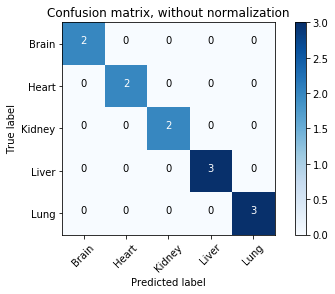

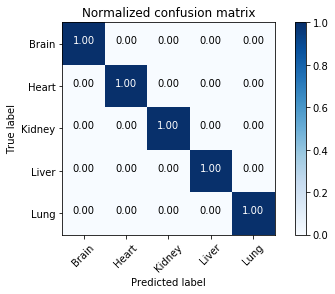

In [76]:
### Confusion matrix shows which labels are being misclassified
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(peptide_y_test, peptide_dt_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=groups,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=groups, normalize=True,
                      title='Normalized confusion matrix')

plt.show()